# Personolized Spotify Wrapped

Austin Martinez

Inspired by a Tiktok and a want for a more visible portfolio, this project uses Spotify's web API to create a personal Spotify Wrapped written entirely in Python.  I do plan to revisit near the end of 2025 to see what has changed and to compare results with the official Spotify wrapped. This notebook looks at my listening history and generates an image with visuals that change in accordance with the data. It generates an "album map" which is the top 4 listened albums averaged together and then passed through a median filter to create an interesting effect. We also use the average color of this album map to decide what color theme to use for the final image. Lastly we use a histogram of the songs' `popularity` field to make the background a little more interesting. If you listen to less popular music, the bars will be right skewed and more left skewed if you tend to favor the top of the billboards. As of writing (1/6/25), there is only about two weeks worth of data.

Data is collected via a script hosted on a remote Ubuntu server that pulls my most recently played songs from Spotify web API ever hour. The script saves the most recently played songs to a csv file using the `played_at` field to make sure there is no overlapping or duplicated data and to only append unrecorded data while also doing some initial cleaning. We then simply pull the csv file that now contains my entire listening history for us in this notebook.

Initially, I planned on doing an in depth statistical analysis for my listening habits using the number of times I listened to a song as the response variable. However a few days before I started working on this project, Spotify deprecated their audio feature API endpoint. This significantly decreased the amount of numeric features that could be used in a statistical model without having to search for, download, then process thousands of songs myself. We could derive more features from the text data. However, I wanted to concentrate on the application of linear models rather than NLMs. My initial concern was that, within black box of neural models, it may simply favor similary to or matches with the most popular artists and song titles. I would say that a band having a name similar to my most listened to band is not grounds for wether I would listen to a song a lot. For instance, let's consider the two bands "Ghost" and "As Ghosts". Their names are very similar and probably have high cosin similarity, but I have not listened to a "Ghost" song in months whereas "As Ghosts" has become one of my favorite artists in the past month.

In leue of working statistical models, I decided to instead challenge myself to make something that I would typically use Photoshop for except entirely in Python. 

## The code

First we import everything we need and clean the album and artist fields as they are initially given to us as JSON. I also chose to explode the data via the artists field as sometimes there are multiple artists on a single song. I had to make a decision on wether a recorded song with multiple artists should count as a single listen for each artist or a single listen for a joint artist entry. I chose the former which does introduce extra rows for a single song. In my case, this did not affect the top results as I didn't listen to many collaberative songs and all top songs were witha single artist. However for a generalized solution, this may need to be reconsidered or could potentially be derived feature for a model. Maybe someone really likes it when artists collaberate. 

In [1]:
import numpy as np
import pandas as pd
import spotipy
import json
import ast
import seaborn as sns
import PIL
from PIL import Image, ImageChops
import urllib.request 
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFilter
from PIL import ImageEnhance

In [2]:
dat = pd.read_csv('pulledDat.csv', index_col=0)

# clean artist(s) object
parsedList = [ast.literal_eval(i) for i in dat['artists']]
dat['artists'] = [[j['name'] for j in i] for i in parsedList]

# clean the album object
albumLiterals = [ast.literal_eval(i) for i in dat['album']]
dat['album_name'] = [i['name'] for i in albumLiterals]
dat['album_release_date'] = [i['release_date'] for i in albumLiterals]
dat['album_length'] = [i['total_tracks'] for i in albumLiterals]
dat['album_cover'] = [i['image'] for i in albumLiterals]

datex = dat.explode('artists')

Here we get the most listened to album covers and average all the pixels into a single image. The resulting image is a little ugly so we run it through a median filter 20 times. This is replicating the "Dust and Scratches" filter in Photoshop, which I like to use. Usually used to remove dust and scratches, if you use this filter with a high threshold (60 or 70) you can create this abstract representation of the original image. From what I understand, the Dust and Scratches filter is actually just a median filter with a threshold slider and a little photoshop processing. Pillow limits the threshold to 19, so instead just apply the filter a bunch of times. It's also important to not use too many album covers in the averaging step as it will eventually become an indistinguishable mess as you add more albums. 4 albums simply felt the most effective while testing. 

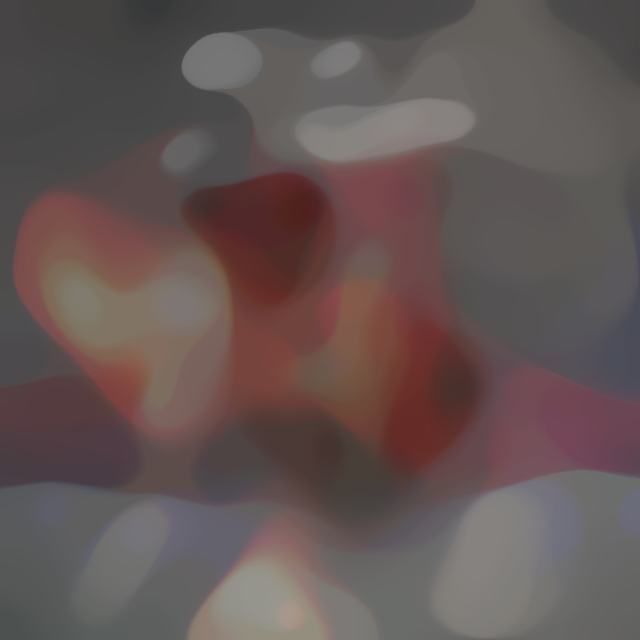

In [3]:
# get basic info of the images
url = datex.iloc[0]['album_cover']
urllib.request.urlretrieve(url, "./img/img.png") 

yuh = pd.DataFrame(datex[['album_cover', 'artists']].value_counts()).reset_index()

# Assuming all images are the same size, get dimensions of first image
img = Image.open(r"./img/img.png") 
w,h=img.size
N=4

# Create a numpy array of floats to store the average (assume RGB images)
arr=np.zeros((h,w,3),float)

# loop through the images
index = 0
for i in yuh['album_cover']:
    urllib.request.urlretrieve(i, "./img/img.png") 
    # Build up average pixel intensities, casting each image as an array of floats
    imarr=np.array(Image.open(r"./img/img.png"),dtype=float)
    arr=arr+imarr/N
    time.sleep(2)
    index += 1
    if (index == N):
        break


# Round values in array and cast as 8-bit integer
arr=np.array(np.round(arr),dtype=np.uint8)

# Generate, save and preview final image
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
a = Image.open(r"Average.png")
for i in range(20):
    a = a.filter(ImageFilter.MedianFilter(size=19))
a

Here we get the average color from this new averaged album cover. However, we are now taking the average of the median of the average of 4 album covers. This somewhat becomes an application of the central limit theorom and will probably result in a very washed and unsaturated color. But we want an interesting color that represents our music taste. To fix this, we hash map our pixel data for use in the next step.

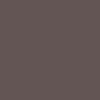

In [4]:
imap = a.load()
ravg = 0
gavg = 0
bavg = 0
x, y = a.size
n = x*y
colorDict = {}
for i in range(640):
    for j in range(640):
        point = imap[i,j]
        if (point in colorDict):
            colorDict[point] += 1
        else:
            colorDict[point] = 0
        ravg += imap[i,j][0]/n
        gavg += imap[i,j][1]/n
        bavg += imap[i,j][2]/n
avgColor = Image.new('RGB', (100, 100), (int(ravg), int(gavg), int(bavg)))
avgColor

Using the hash map, we only consider the most promonent colors that favor an RBG channel enough and take the average of the top 10. This result is a less bland, but still too bland color. To fix this, we then increase the saturation to get the overall color theme of the album average or "Album Map". This is really just a more complicated way of doing what we previously did to get only a slightly better result. But we do this to consider only the visibly "important" colors of our album map. If an average is almost entirely black with some notable blue splotches, it would make more sense  and look better to make the theme blue rather than black. 

[(119, 67, 61), (120, 72, 76), (112, 68, 60), (124, 80, 74), (101, 44, 40), (114, 75, 84), (106, 69, 83), (111, 73, 74), (116, 70, 88), (101, 44, 39), (127, 90, 74)]


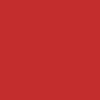

In [5]:
sortedDict = {k: v for k, v in sorted(colorDict.items(), key=lambda item: item[1], reverse=True)}
selection = []
for key in sortedDict:
    avgDiff = 0
    avgDiff += (key[0]-key[1])**2 / 3
    avgDiff += (key[0]-key[1])**2 / 3
    avgDiff += (key[1]-key[2])**2 / 3
    if (avgDiff > 800 and (key[0] > 100 or key[1] > 100 or key[2] > 100)):
        selection.append(key)
    if (len(selection) > 10):
        break
    
print(selection)

ra = 0
ba = 0
ga = 0
for i in selection:
    ra += i[0]/10
    ba += i[1]/10
    ga += i[2]/10
    
avgColor = Image.new('RGB', a.size, (int(ra),int(ba),int(ga)))
converter = ImageEnhance.Color(avgColor)
avgc = converter.enhance(3).load()[0,0]
Image.new('RGB', (100, 100), avgc)

Even after all of that, the color will probably be ugly. So instead we make our own "pretty" color pallette and choose a color from the pallette that is closest to our average color by euclidean distance. 

(242, 34, 34)


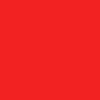

In [6]:
# get like 5 or 6 colors
colorThemes = [
    (242, 75, 198),
    (7, 43, 242),
    (53, 242, 223),
    (242, 190, 92),
    (242, 34, 34),
]
# treating the rgb values as points, find the closest euclidian distance and choose that color as the theme
def euclidianDistance(v1, v2):
    return ((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2 + (v1[2] - v2[2])**2)**0.5

chosenColor = None
m = 999
for i in colorThemes:
    dist = euclidianDistance(avgc, i)
    if (dist < m):
        m = dist
        chosenColor = i
print(chosenColor)
Image.new('RGB', (100, 100), (chosenColor[0], chosenColor[1], chosenColor[2]))

From here on out, we are just putting things together to make the final image. First step is to create some perlin noise to add some texture to the image (it kinda gets filtered out but this can be adjusted). 

In [7]:
# Generate noise image array
noise1 = PerlinNoise(octaves=3)
noise2 = PerlinNoise(octaves=6)
noise3 = PerlinNoise(octaves=12)
noise4 = PerlinNoise(octaves=24)

xpix, ypix = 1080, 1920
pic = []
for i in range(xpix):
    row = []
    for j in range(ypix):
        noise_val = noise1([i/xpix, j/ypix])
        noise_val += 0.5 * noise2([i/xpix, j/ypix])
        noise_val += 0.25 * noise3([i/xpix, j/ypix])
        noise_val += 0.125 * noise4([i/xpix, j/ypix])
        # pic.append(noise_val)
        row.append(noise_val)
    pic.append(row)

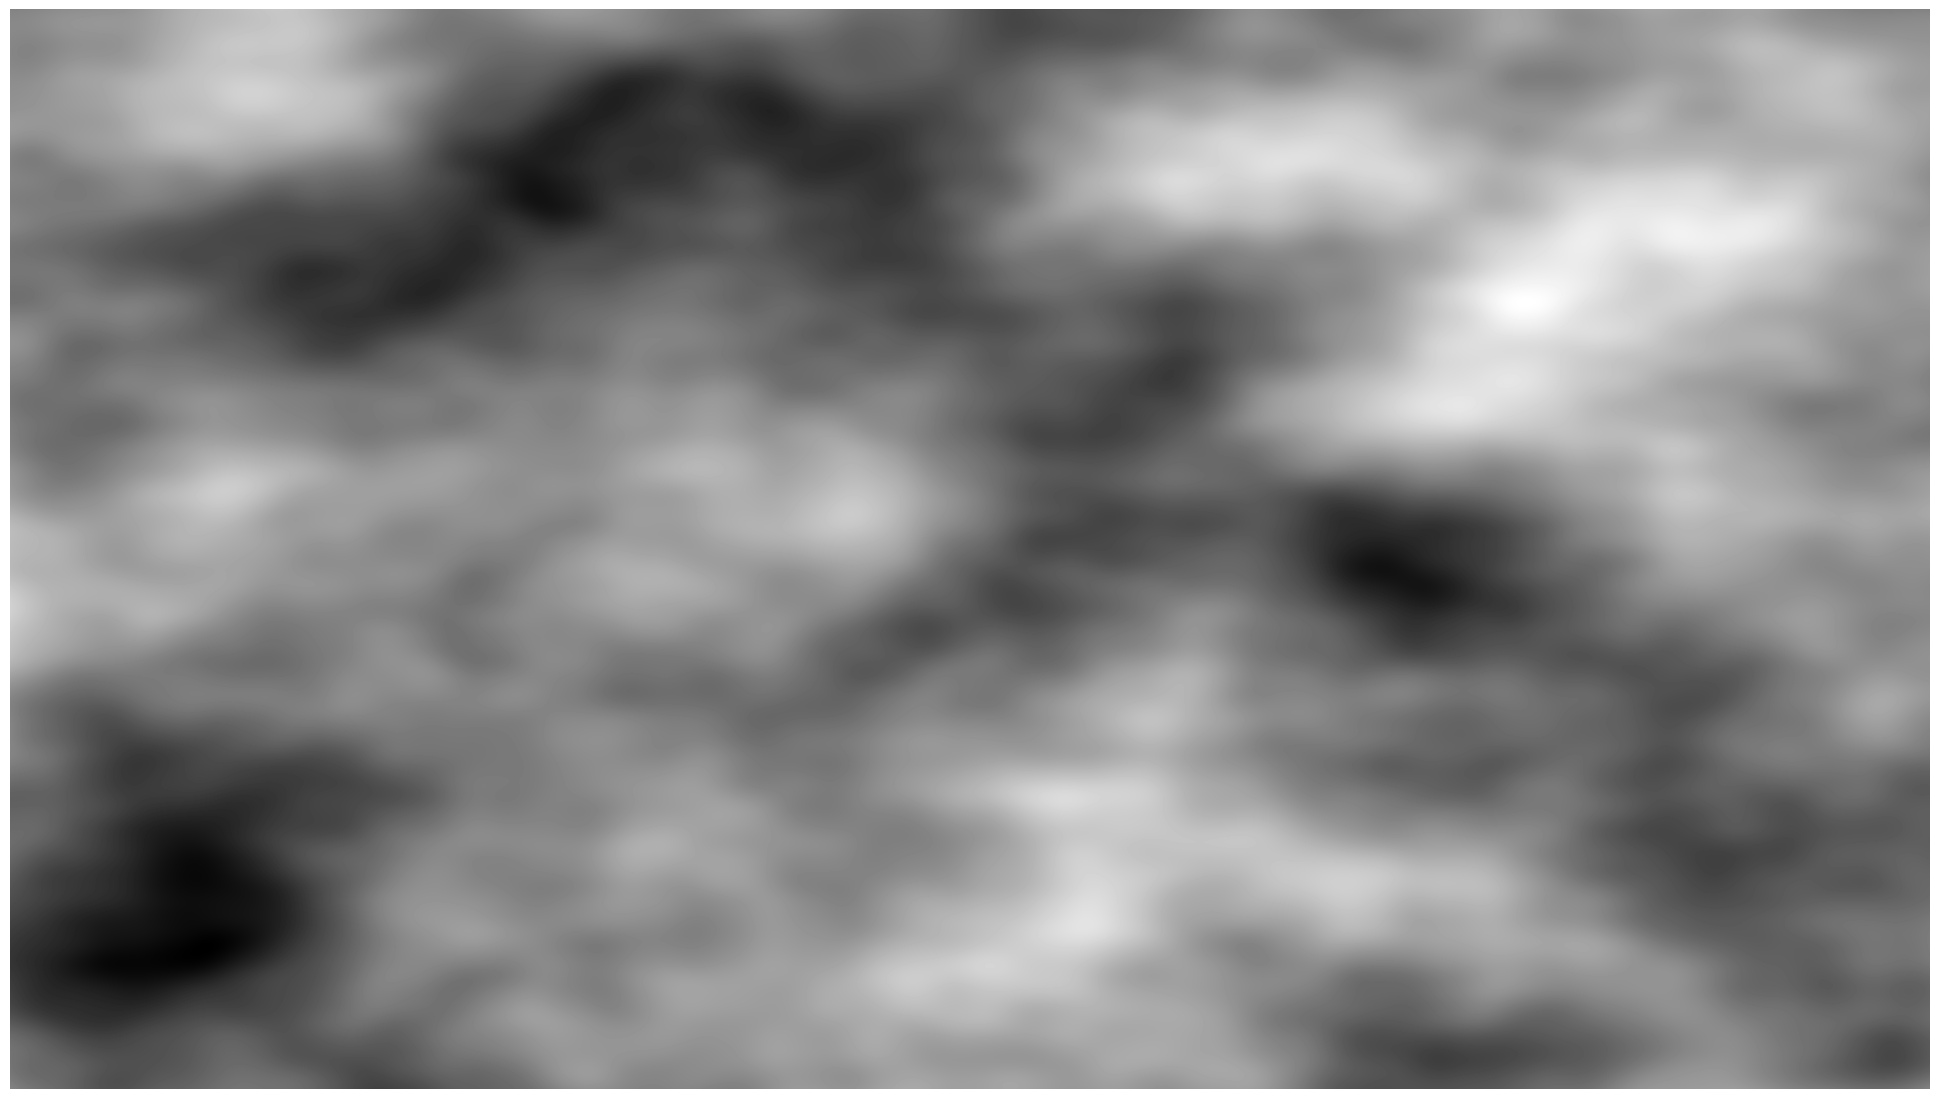

In [8]:
# Save noise image array to `noise.png`
myDpi = 96
fig = plt.figure(figsize=(1920/myDpi, 1080/myDpi), dpi=myDpi, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pic, aspect='auto', cmap='gray')
plt.savefig('noise.png')

This is our popularity histogram to be used in the background. I tend to listen to smaller, more indie, artists so the bars will be more towards the left. If someone consistently listens to more popular music, the bars will be more towards the right side. Here we make a plt histogram at 1080p with a black background and save it to file.

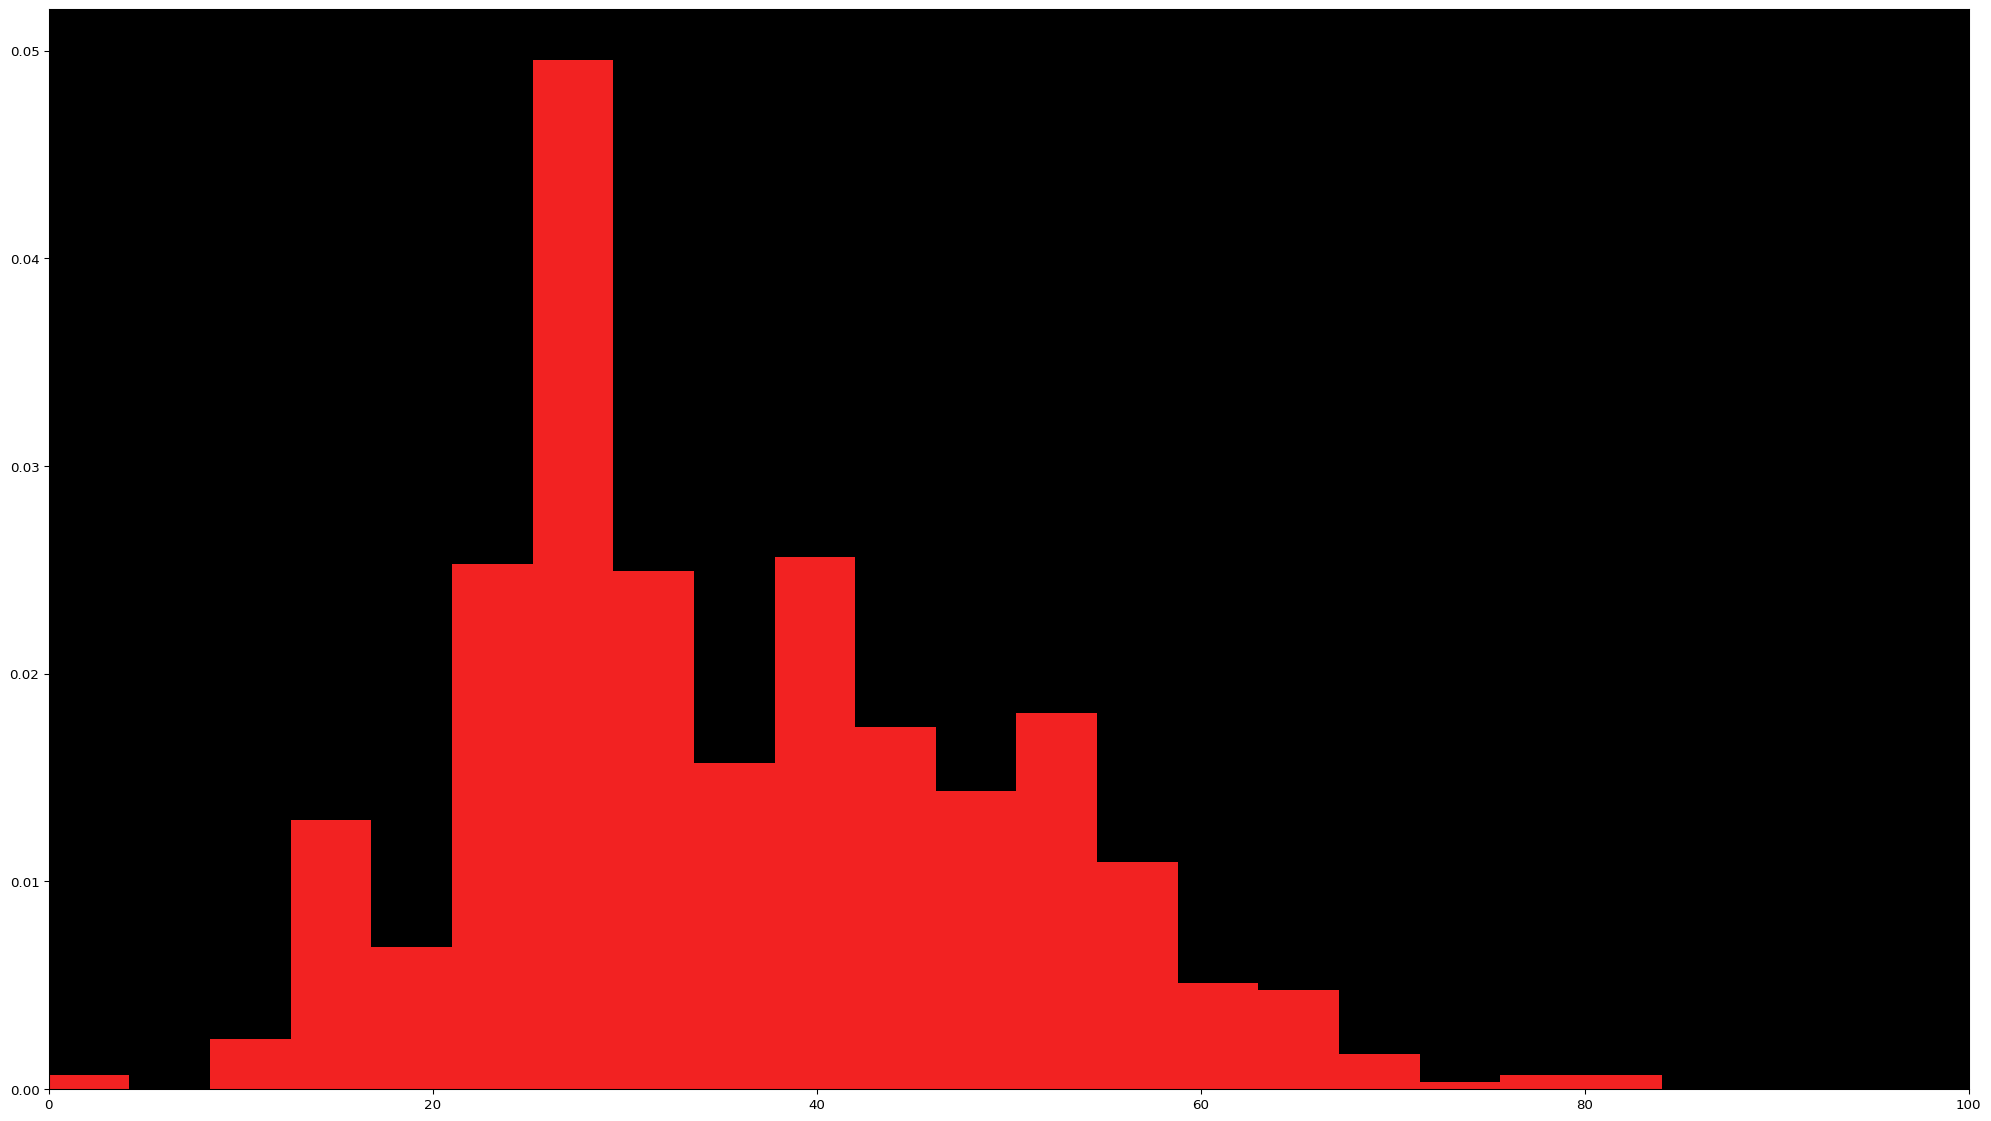

In [9]:
myDpi = 96
fig = plt.figure(figsize=(1920/myDpi, 1080/myDpi), dpi=myDpi, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_facecolor("black")
# ax.set_axis_off()
fig.add_axes(ax)
plt.xlim([0, 100])
ax.hist(datex['popularity'] , bins=20, density=True, color = (chosenColor[0] / 255, chosenColor[1] / 255, chosenColor[2] / 255) )
plt.savefig('foo.png')

Start combining every the noise and the bars to make the background. Make sure to darken it.

In [10]:
baseImage = Image.new('RGB', (1920, 1080)).convert("RGB")
noise = Image.open('noise.png').convert("RGB")
overlayColor = Image.new('RGB', (1920, 1080), chosenColor).convert("RGB")
blackColor = Image.new('RGB', (1920, 1080), (120,120,120)).convert("RGB")
bars = Image.open('foo.png').convert("RGB")

baseImage.paste(blackColor)
baseImage.paste(bars)
baseImage = ImageChops.multiply(baseImage, blackColor) 
baseImage = ImageChops.multiply(baseImage, blackColor) 
baseImage = ImageChops.multiply(baseImage, blackColor) 

baseImage = Image.blend(baseImage, noise, alpha=0.4)
j = Image.blend(baseImage, overlayColor, alpha=0.25)
j = ImageChops.multiply(j, bars) 
j = ImageChops.multiply(j, overlayColor) 
j = ImageChops.multiply(j, overlayColor) 
j = ImageChops.multiply(j, blackColor) 

Add the high level data as text to the image and the border for the album map. Lastly add a slight glow to everything.

In [11]:
def truncateText(text, maxLength=15):
    if (len(text) >= maxLength):
        return text[:15].strip() + '...'
    else:
        return text

font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 80)
gr = ImageDraw.Draw(j)
gr.text((60,30), "Personal Spotify Wrapped", font=font, fill=chosenColor)


# Minutes Listened
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 130)
gr.text((60,130), str(int(sum(dat['duration_ms'])/1000/60/60)), font=font, fill=chosenColor)

font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
gr.text((250,235), 'hours listened', font=font, fill=chosenColor)


# Top Artists
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 60)
gr.text((60,330), 'Top 5 Songs', font=font, fill=chosenColor)

font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
topSong = pd.DataFrame(datex[['name', 'artists']].value_counts()).reset_index().head(5)
pixelOffset = 0
for index,row in topSong.iterrows():
    text = truncateText(str(row['name']))
    gr.text((60,410 + pixelOffset), str(index+1) + '. ' + text, font=font, fill=chosenColor)
    pixelOffset += 50

    
# Top Songs
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 60)
gr.text((630,330), 'Top 5 Artists', font=font, fill=chosenColor)

font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
topSong = pd.DataFrame(datex[['artists']].value_counts()).reset_index().head(5)
pixelOffset = 0
for index,row in topSong.iterrows():
    text = truncateText(str(row['artists']))
    gr.text((630,410 + pixelOffset), str(index+1) + '. ' + text, font=font, fill=chosenColor)
    pixelOffset += 50

    
# Other Stats
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 120)
gr.text((60,730), str(len(pd.unique(datex['artists']))), font=font, fill=chosenColor)
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
gr.text((60,880), 'Unique artists', font=font, fill=chosenColor)

# Unique Songs
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 120)
gr.text((630,730), str(len(pd.unique(datex['name']))), font=font, fill=chosenColor)
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
gr.text((630,880), 'Unique Songs', font=font, fill=chosenColor)

# Album Map
font = ImageFont.truetype('./converted-fonts/IntegralCF-Regular.ttf', 40)
gr.text((1280,290), 'Album Map', font=font, fill=chosenColor)

# Resize the averaged image
base_width = a.size[0]
wpercent = (base_width / float(a.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = a.resize((500, 500), Image.Resampling.LANCZOS)
img = ImageChops.overlay(img,img)

# apply layers in order for the album map border
img_w, img_h = img.size
bg_w, bg_h = j.size
border = Image.blend(img, Image.new('RGB', img.size, chosenColor), alpha=1)
offsetX = int((bg_w - img_w) / 1.1)
offsetY = int((bg_w - img_w) / 4)
           
offset = (offsetX + 10, offsetY - 10)
j.paste(border, offset)

offset = (offsetX + 10, offsetY + 10)
j.paste(border, offset)

offset = (offsetX - 10, offsetY + 10)
j.paste(border, offset)

offset = (offsetX - 10, offsetY - 10)
j.paste(border, offset)

im1 = j.filter(ImageFilter.GaussianBlur(radius = 4))
j = ImageChops.screen(j, im1)

The glow will affect the album map color, so we add it last and after the glow is applied.

In [12]:
offset = (offsetX, offsetY)
j.paste(img, offset)

The final result!

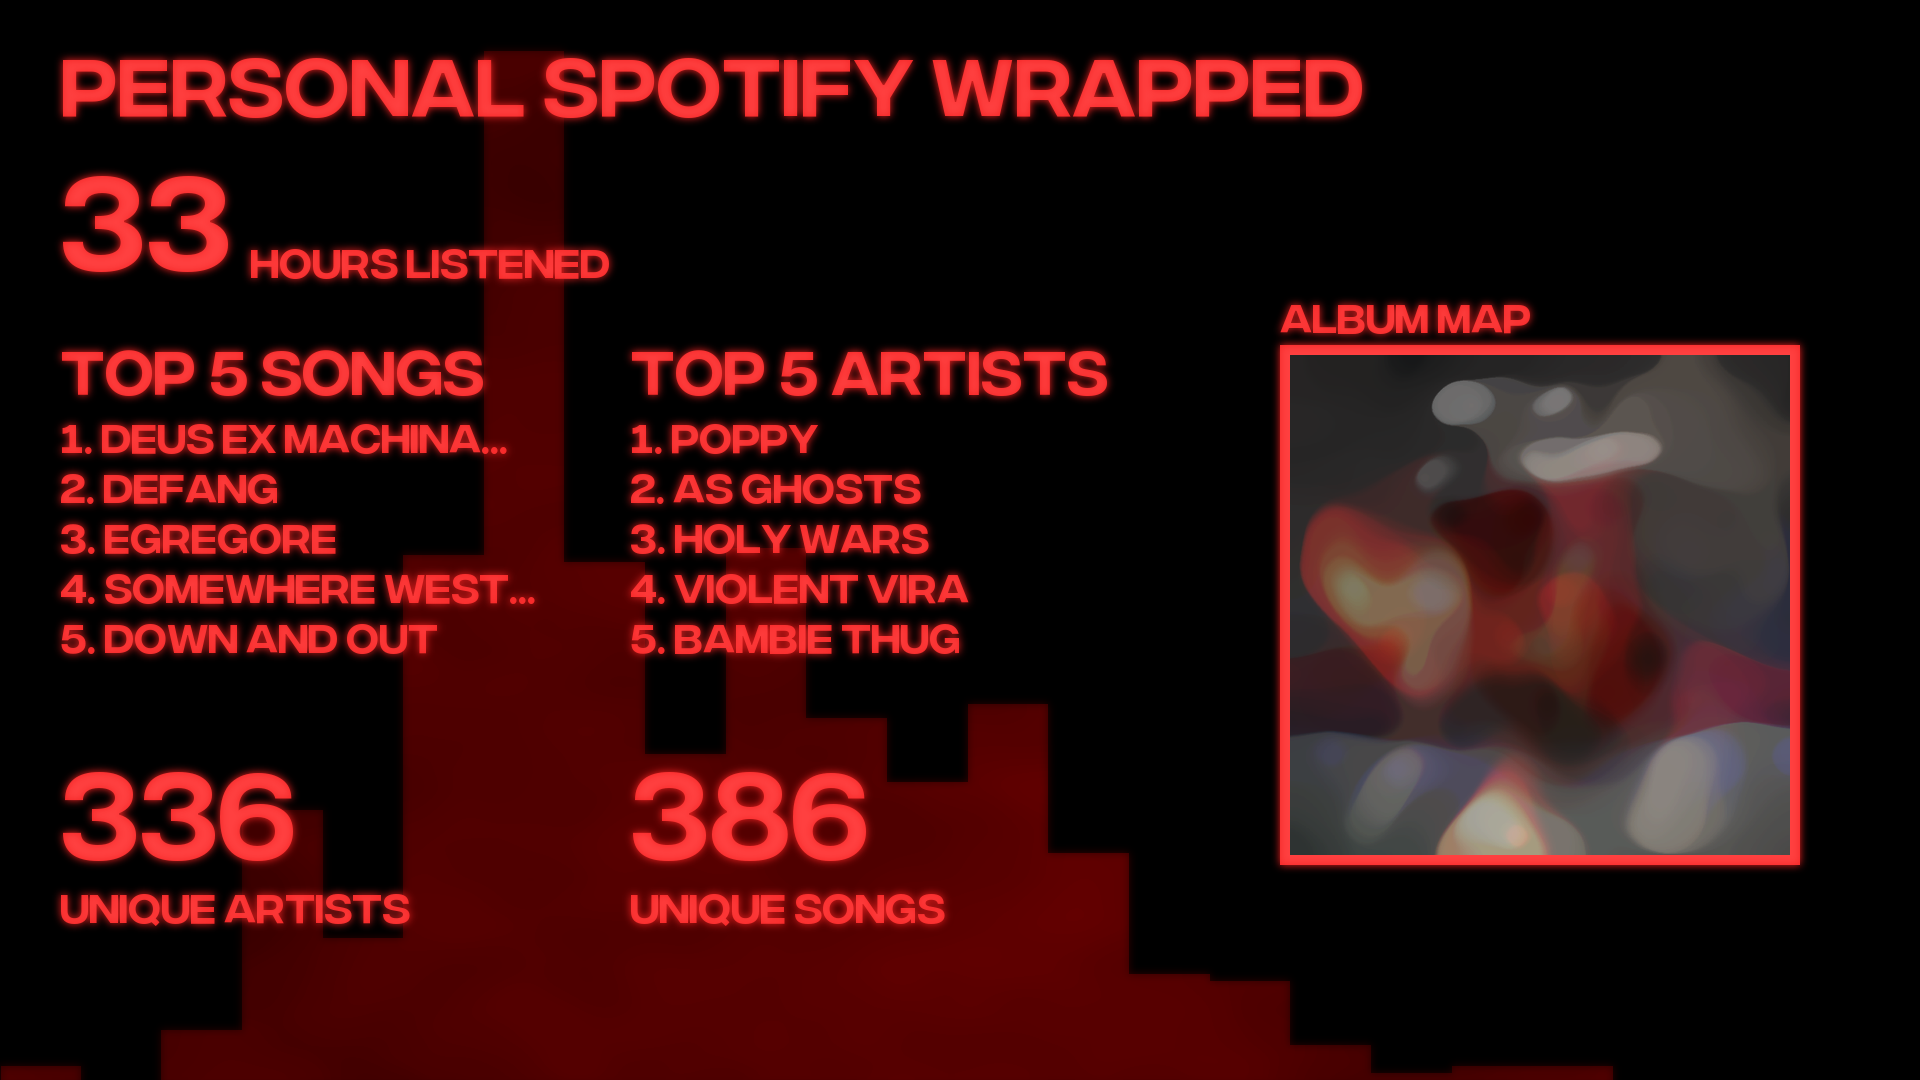

In [13]:
j

This image below uses the bottom 50 songs to generate a different Album Map to show alternative colors. To clarify, only the album maps was changed here to get a different color theme. 

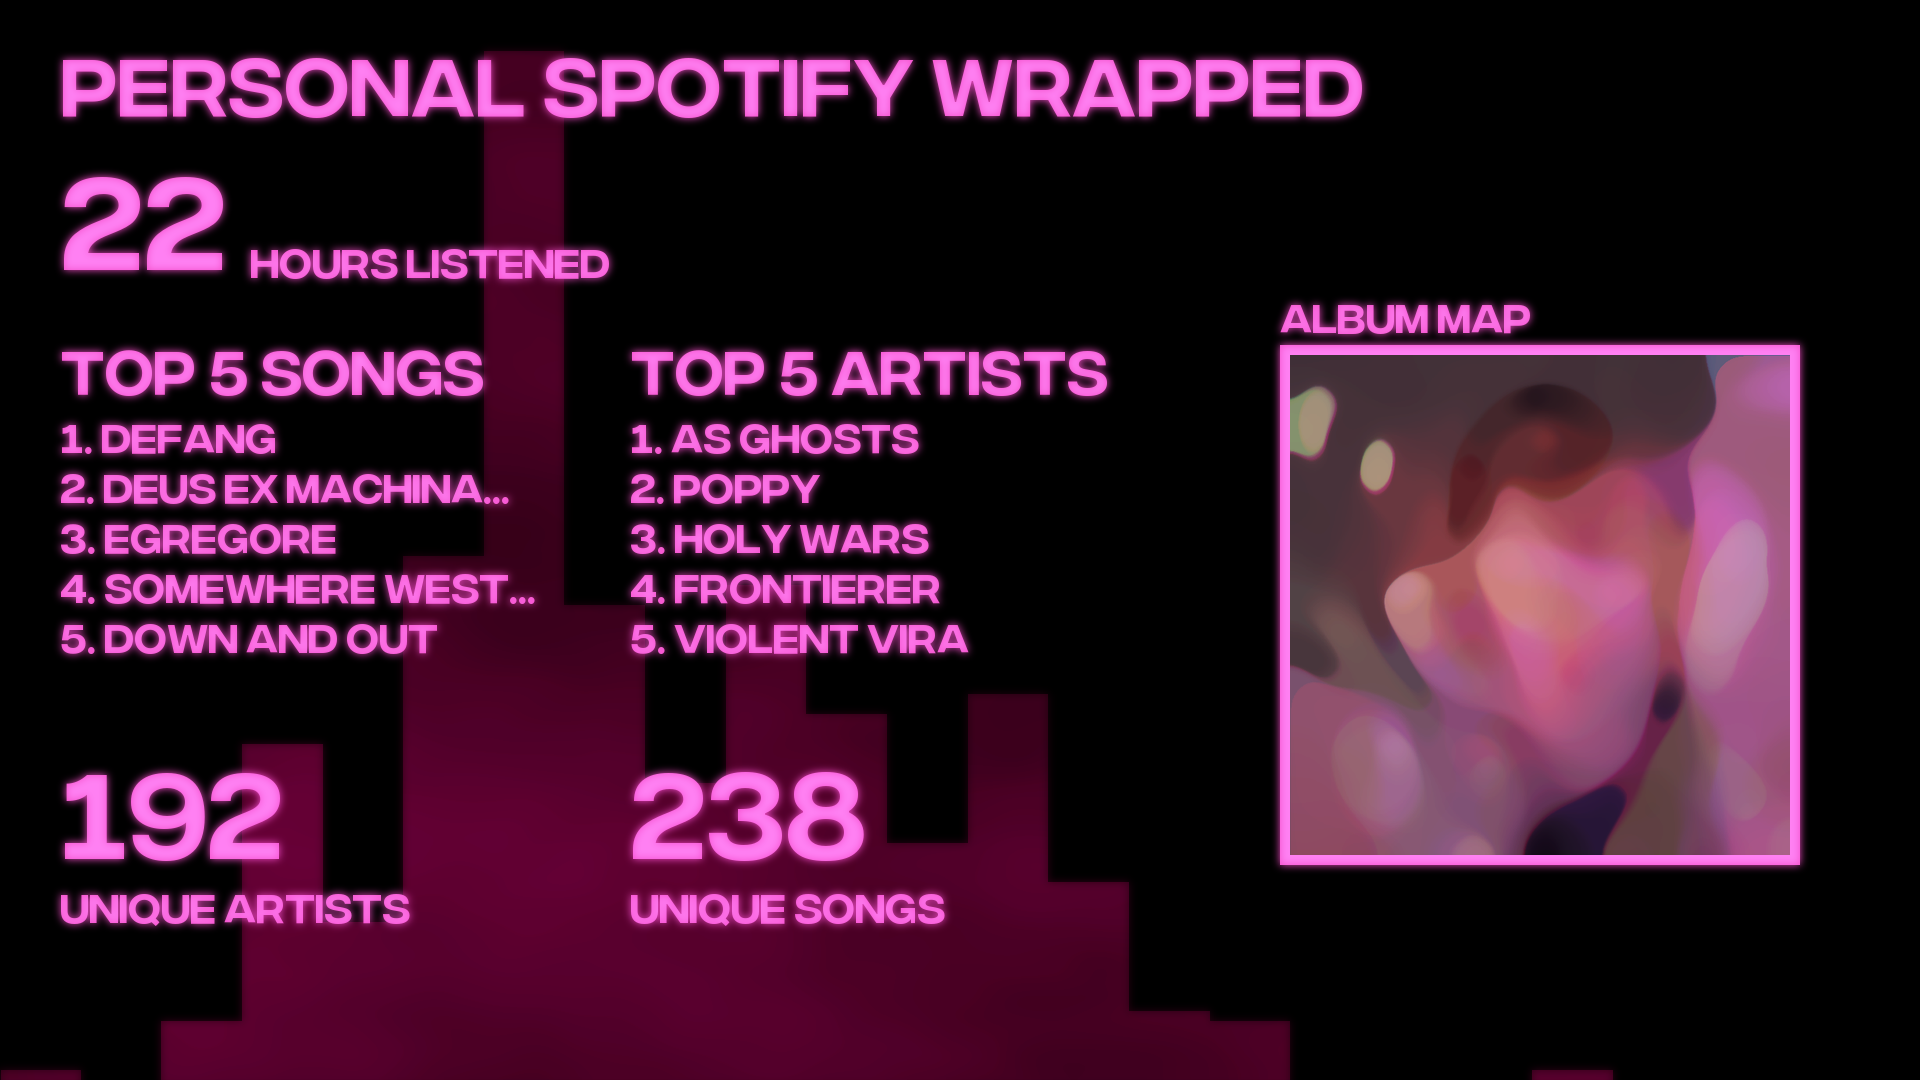

In [14]:
Image.open(r"pink.png")